In [28]:
import numpy as np
import matplotlib as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [29]:
import torch
from torch import nn


class IMVTensorLSTM(torch.jit.ScriptModule):
    
    __constants__ = ["n_units", "input_dim"]
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_i = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_f = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_o = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_i = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_f = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_o = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_i = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_f = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_o = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    
    @torch.jit.script_method
    def forward(self, x):
        # h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        # c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units)
        c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units)
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            # eq 1
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            # eq 5
            i_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_i) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_i) + self.b_i)
            f_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_f) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_f) + self.b_f)
            o_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_o) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_o) + self.b_o)
            # eq 6
            c_tilda_t = c_tilda_t*f_tilda_t + i_tilda_t*j_tilda_t
            # eq 7
            h_tilda_t = (o_tilda_t*torch.tanh(c_tilda_t))
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        # eq 8
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n) +self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)
        
        return mean, alphas, betas

    
class IMVFullLSTM(torch.jit.ScriptModule):
    __constants__ = ["n_units", "input_dim"]
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.W_i = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.W_f = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.W_o = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    @torch.jit.script_method
    def forward(self, x):
        # h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        # c_t = torch.zeros(x.shape[0], self.input_dim*self.n_units).cuda()
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units)
        c_t = torch.zeros(x.shape[0], self.input_dim*self.n_units)
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            # eq 1
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            inp =  torch.cat([x[:, t, :], h_tilda_t.view(h_tilda_t.shape[0], -1)], dim=1)
            # eq 2
            i_t = torch.sigmoid(self.W_i(inp))
            f_t = torch.sigmoid(self.W_f(inp))
            o_t = torch.sigmoid(self.W_o(inp))
            # eq 3
            c_t = c_t*f_t + i_t*j_tilda_t.view(j_tilda_t.shape[0], -1)
            # eq 4
            h_tilda_t = (o_t*torch.tanh(c_t)).view(h_tilda_t.shape[0], self.input_dim, self.n_units)
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        # eq 8
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n) +self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)
        return mean, alphas, betas

In [30]:
#from IMV_LSTM.networks import IMVTensorLSTM

In [31]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [32]:
data = pd.read_csv("./rawpollution.csv")

In [33]:
cbwd = pd.get_dummies(data['cbwd'])
cbwd.columns = ["cbwd_{}".format(i) for i in range(cbwd.shape[1])]
data = pd.concat([data, cbwd], axis=1)

In [34]:
data.drop(['cbwd'], axis=1, inplace=True)

In [35]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_0,cbwd_1,cbwd_2,cbwd_3
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


In [36]:
cols = list(data.columns[5:])

In [37]:
cols

['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_0',
 'cbwd_1',
 'cbwd_2',
 'cbwd_3']

In [38]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [39]:
depth = 10

In [40]:
X = np.zeros((len(data), depth, len(cols)))
for i, name in enumerate(cols):
    for j in range(depth):
        X[:, j, i] = data[name].shift(depth - j - 1).fillna(method='bfill')

In [41]:
y = data['pm2.5'].shift(-1).fillna(method='ffill').values

In [42]:
train_bound = int(0.6*(len(data)))
val_bound = int(0.8*(len(data)))

In [43]:
X_train = X[:train_bound]
X_val = X[train_bound:val_bound]
X_test = X[val_bound:]
y_train = y[:train_bound]
y_val = y[train_bound:val_bound]
y_test = y[val_bound:]

In [44]:
X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

In [45]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min +1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [46]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

In [47]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [48]:
model = IMVTensorLSTM(X_train_t.shape[2], 1, 128)

In [49]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.06206837418251546 val:  0.053870540809219464
lr:  0.001
mse:  2867.315 mae:  33.414543


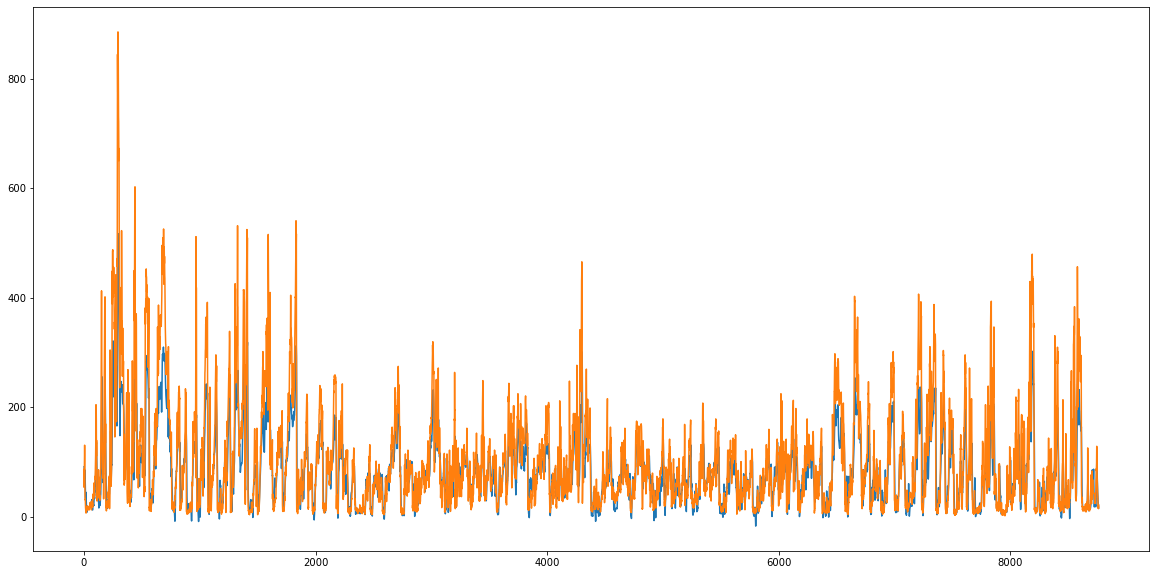

Saving...
Iter:  1 train:  0.039356175850147015 val:  0.03198768745131169
Saving...
Iter:  2 train:  0.030365320313418587 val:  0.02746547590207721
Saving...
Iter:  3 train:  0.025373620100212223 val:  0.024758873124204564
Saving...
Iter:  4 train:  0.02420679103390706 val:  0.02415166667734149


In [52]:
#epochs = 1000
epochs = 5
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        # batch_x = batch_x.cuda()
        # batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            # batch_x = batch_x.cuda()
            # batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_tensor_lstm_pm25.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("lr: ", opt.param_groups[0]["lr"])
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [53]:
model.load_state_dict(torch.load("imv_tensor_lstm_pm25.pt"))

<All keys matched successfully>

In [54]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
#        batch_x = batch_x.cuda()
#        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [55]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [56]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [57]:
mse, mae

(468.31573, 12.952469)

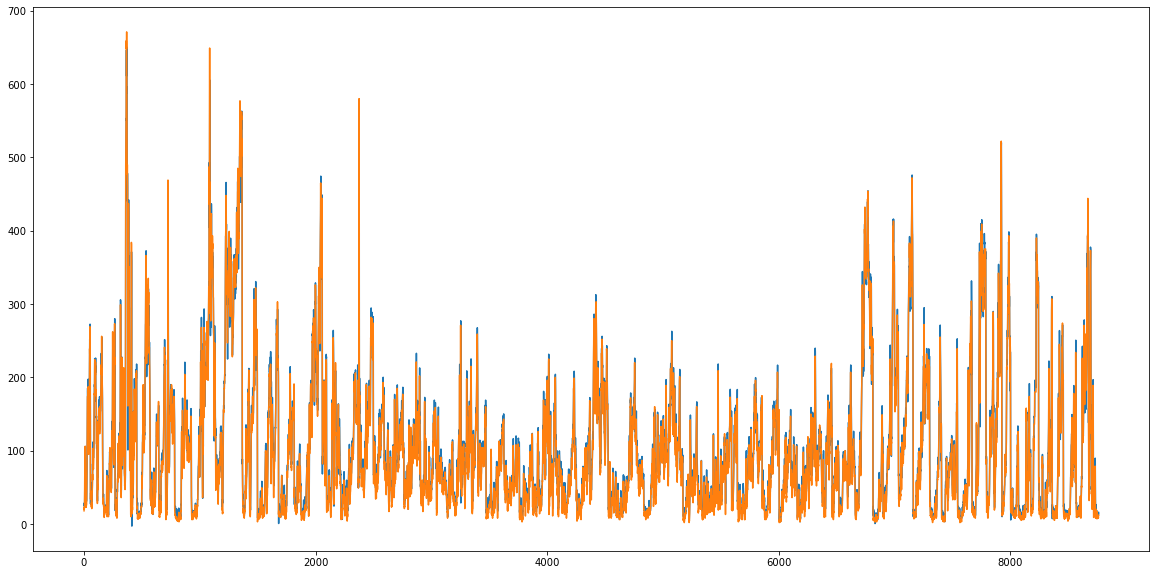

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [59]:
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [60]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [61]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [62]:
alphas = alphas.transpose(1, 0)

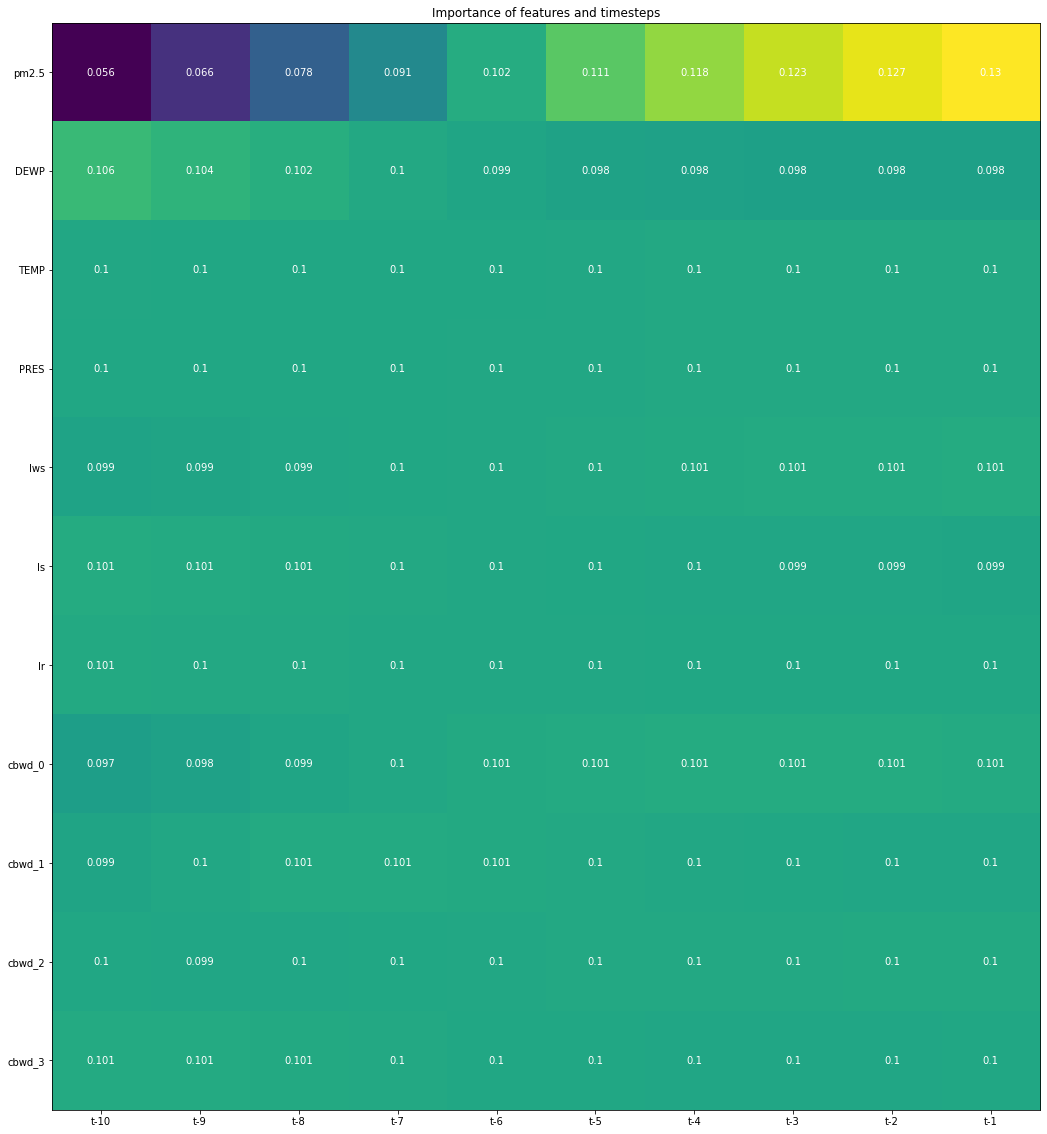

In [63]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(list(cols))
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x109b9508>,
 [Text(0, 0, 'pm2.5'),
  Text(0, 0, 'DEWP'),
  Text(0, 0, 'TEMP'),
  Text(0, 0, 'PRES'),
  Text(0, 0, 'Iws'),
  Text(0, 0, 'Is'),
  Text(0, 0, 'Ir'),
  Text(0, 0, 'cbwd_0'),
  Text(0, 0, 'cbwd_1'),
  Text(0, 0, 'cbwd_2'),
  Text(0, 0, 'cbwd_3')])

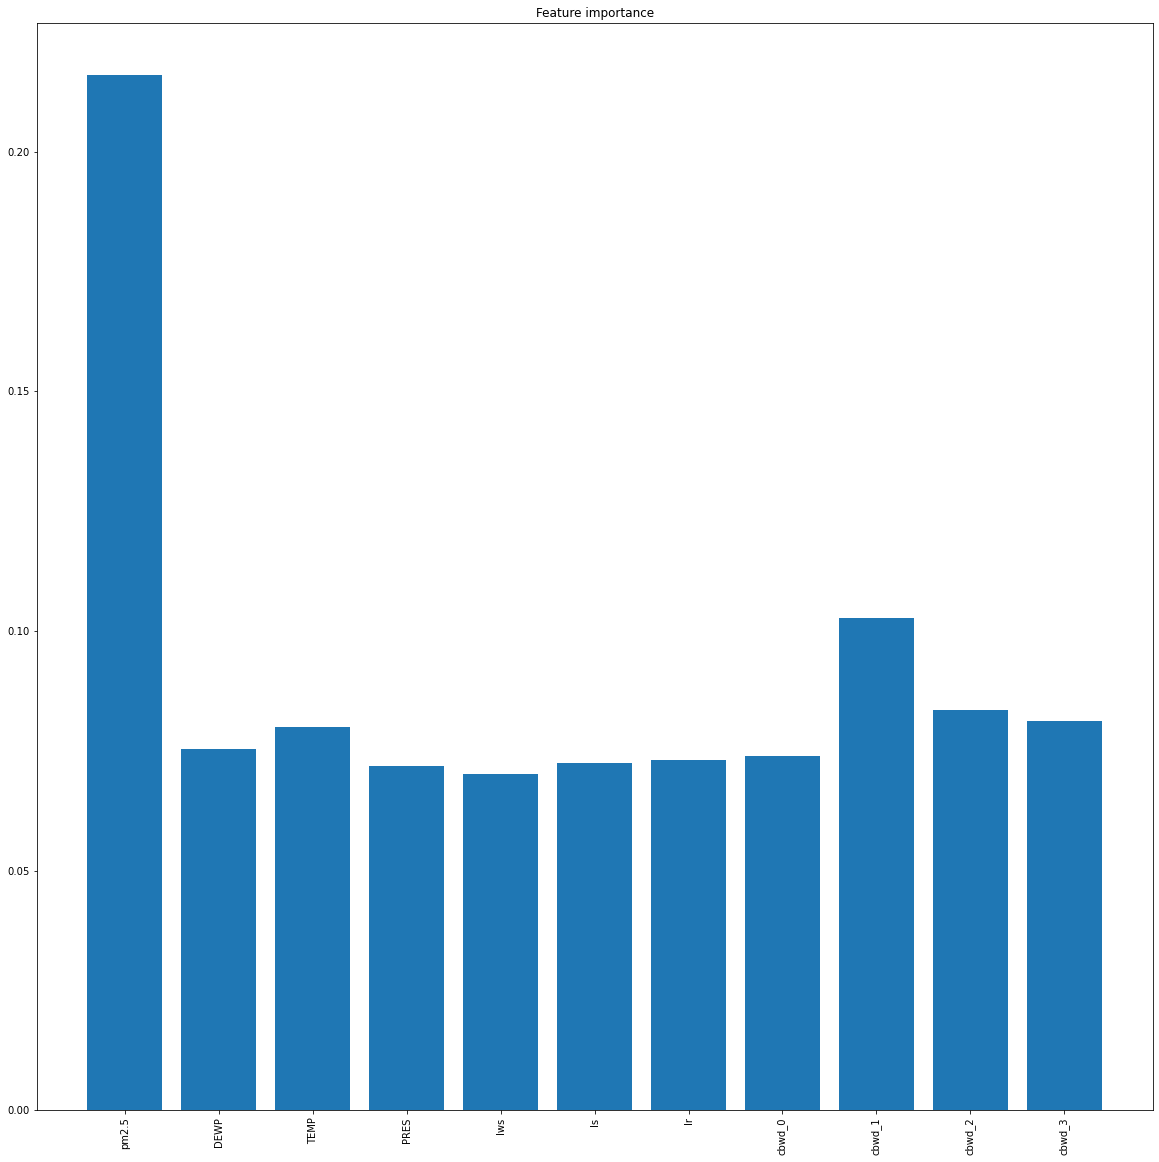

In [64]:
plt.figure(figsize=(20, 20))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)